In [5]:
%matplotlib notebook

import pandas
from numpy import nan
from Brett import db
from matplotlib import pyplot

In [6]:
ROOT = '/scr-ssd/mimic/'
RESP_WINDOW_SCALE = 5
WINDOW_SIZE = 500

In [7]:
def read_rec(recID, part='train'):
    path = ROOT + '/' + part + '/' + str(recID[0]) + '_' + str(recID[1]).zfill(4)
    return db.read_record(path)

In [17]:
def should_flip(wave, sig):
    if sig not in ['I', 'II', 'III', 'V', 'AVR', 'AVF', 'AVL', 'MCL', 'MCL1']:
        return False
    a, b, c = wave.min(), wave.mean(), wave.max()
    return (c - b) < (b - a)

In [18]:
def get_wave(rec, sig, index):
    scale = RESP_WINDOW_SCALE if sig == 'RESP' else 1
    window = slice(index - WINDOW_SIZE * scale, index, scale)
    wave = rec.p_signal[window, rec.sig_name.index(sig)]
    if should_flip(wave, sig): wave *= -1
    return wave

In [10]:
def plot_waves(rec, index, sigs):
    pyplot.figure()
    pyplot.subplots_adjust(wspace=0, hspace=0)
    for sig in sigs:
        ax = pyplot.subplot(len(sigs), 1, sigs.index(sig) + 1)
        ax.plot(get_wave(rec, sig, index))

In [35]:
def plot_group_waves(recs, good_data, bad_data, sig, ncols, nrows):
    assert(all(len(data) >= (ncols * nrows) for data in [good_data, bad_data]))
    pyplot.figure(figsize=[7,6])
    pyplot.subplots_adjust(wspace=0, hspace=0)
    for i in range(ncols*nrows*2):
        data = good_data if i < (nrows * ncols) else bad_data
        color = 'darkblue' if i < (nrows * ncols) else 'darkred'
        rec = recs[data.index[i % (nrows * ncols)]]
        index = data['index'][i % (nrows * ncols)]
        ax = pyplot.subplot(nrows*2, ncols, i + 1)
        ax.plot(get_wave(rec, sig, index), color)
        pyplot.axis('off')

In [12]:
metadata = pandas.read_csv(ROOT + 'metadata.csv')
labels = pandas.read_csv('clean_labels_100.csv')
labels['clean'] = labels.all(1)
k = ['record_id', 'segment']
labels.set_index(k, inplace=True)
metadata = metadata.set_index(k).reindex(labels.index)
read_list = lambda i: eval(i) if type(i) is str else []
list_cols = ['icd_codes', 'sig_name']
metadata[list_cols] = metadata[list_cols].applymap(read_list)
metadata[['index', 'clean']] = labels[['index', 'clean']]

In [37]:
clean = metadata['clean']
hypertensive = metadata['icd_codes'].apply(lambda i: '4019' in i)
afib = metadata['icd_codes'].apply(lambda i: '42731' in i)
chf = metadata['icd_codes'].apply(lambda i: '4280' in i)
ath = metadata['icd_codes'].apply(lambda i: '41401' in i)
pleur = metadata['icd_codes'].apply(lambda i: '5119' in i)

In [14]:
codes_heart = ['4019', '4589', '4280', '42731', '42732', '41401', '41400', '2724', '2720']
healthy = metadata['icd_codes'].apply(lambda i: all(j not in i for j in codes_heart))

In [15]:
recs = {i: read_rec(i) for i in metadata.index}

<IPython.core.display.Javascript object>


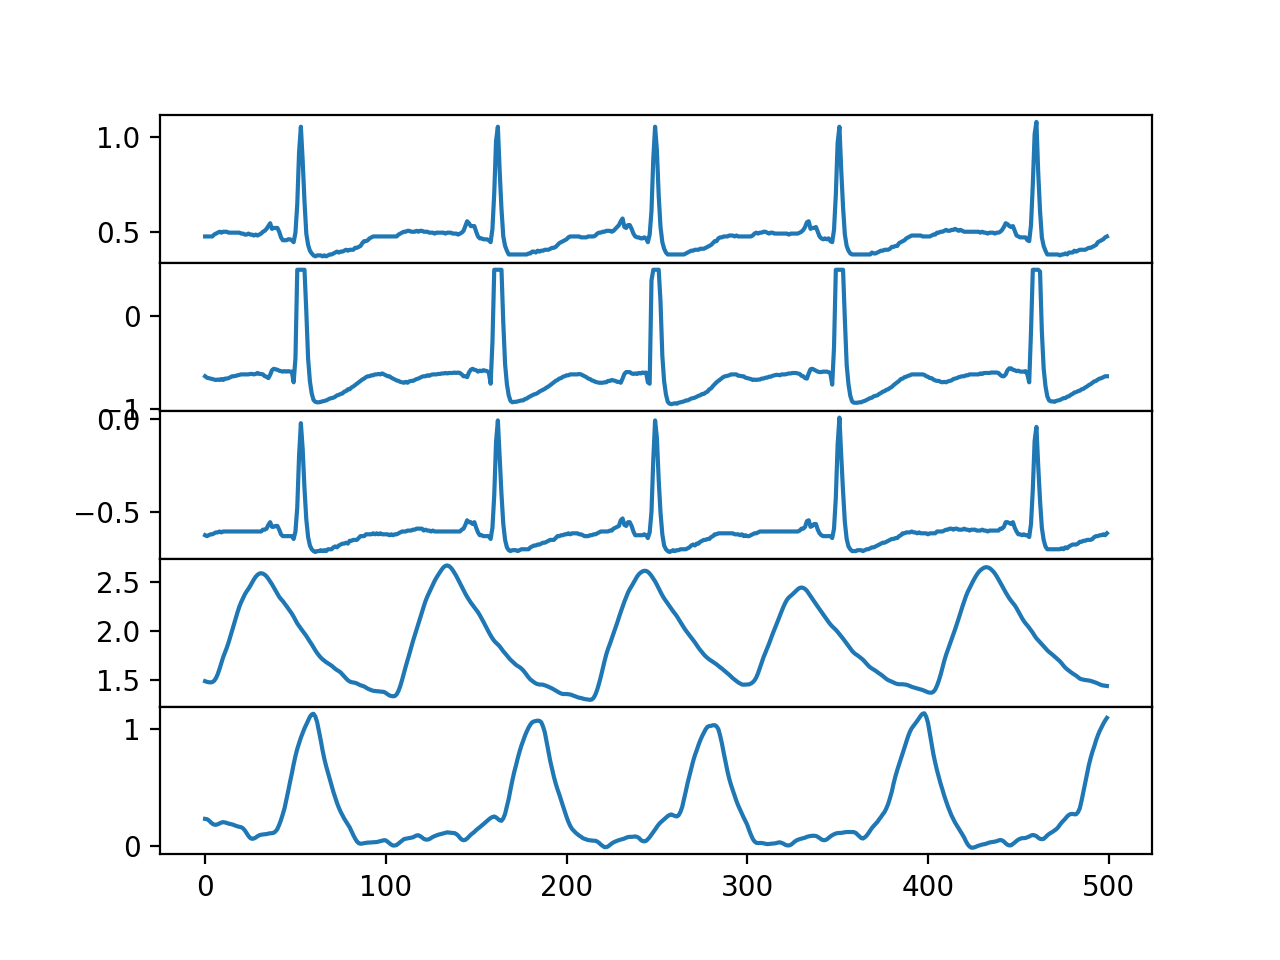

In [19]:
args = lambda i: {
    'rec': recs[metadata[clean].index[i]],
    'index': metadata[clean]['index'][i],
    'sigs': ['II', 'V', 'AVR', 'PLETH', 'RESP']
}
plot_waves(**args(1))

<IPython.core.display.Javascript object>


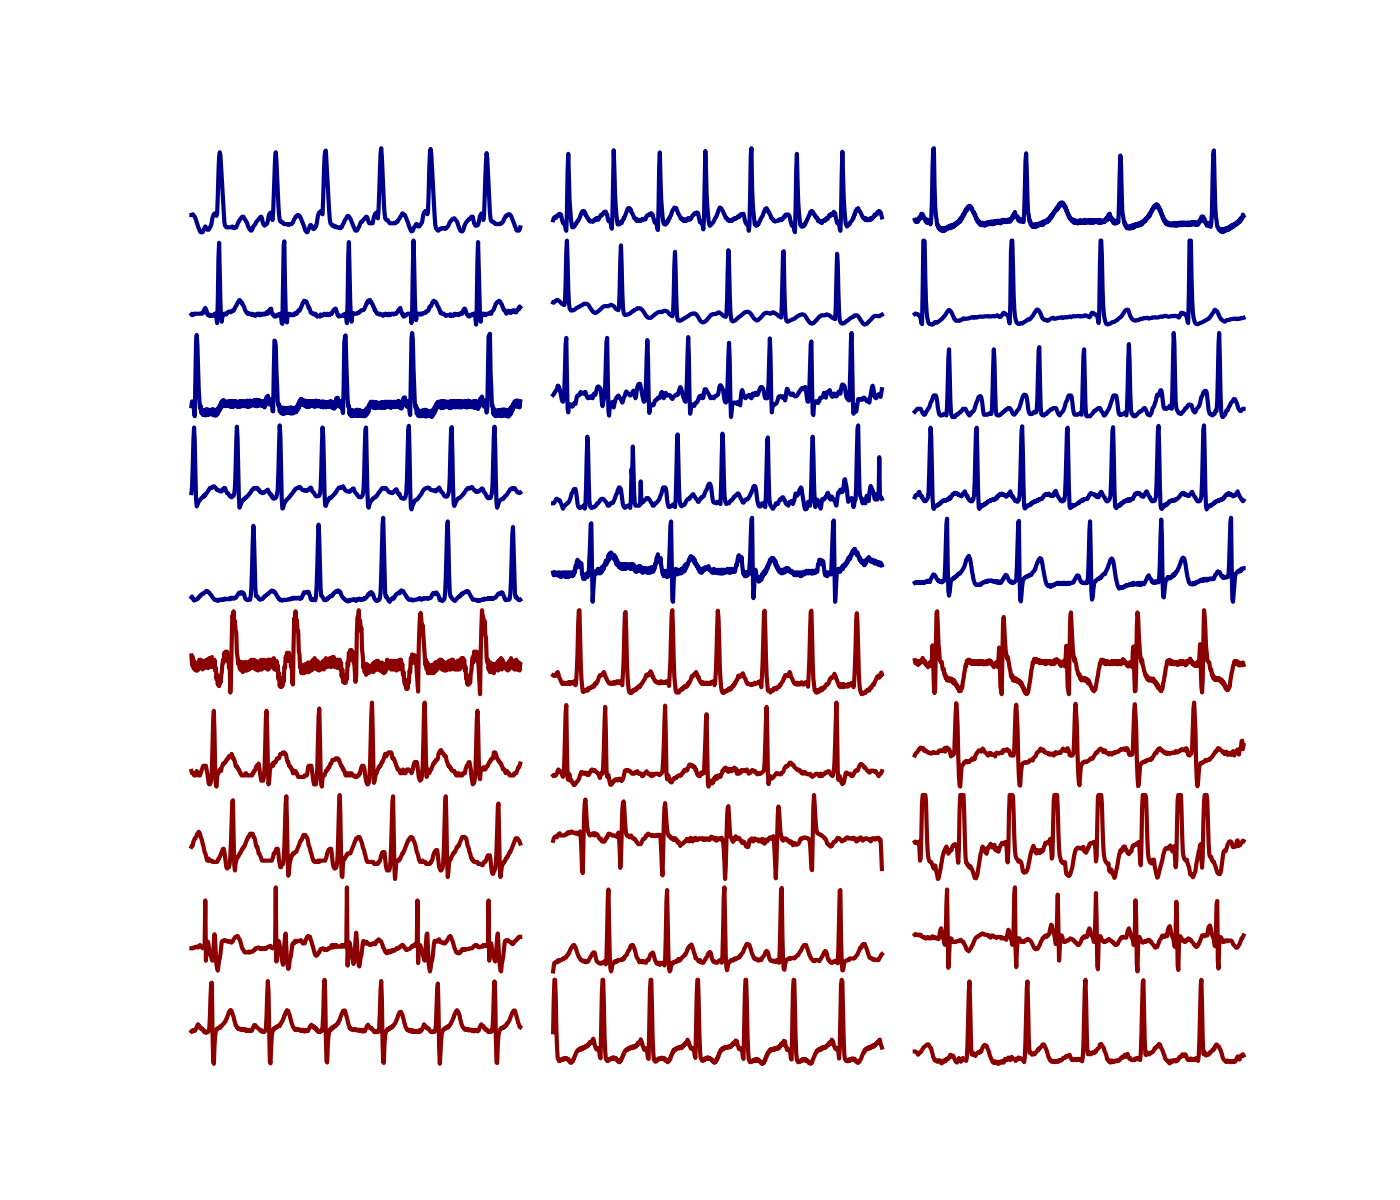

In [44]:
plot_group_waves(
    recs = recs,
    good_data = metadata[clean & healthy],
    bad_data = metadata[clean & chf],
    nrows = 5,
    ncols = 3,
    sig = 'AVR'
)